<img src = "./resources/images/banner_4.jpeg" alt = "Encabezado MLDS" width = "100%">  </img>

# **Modelamiento y Validación**
---

## **0. Integrantes del equipo de trabajo**
---

<table><thead>
  <tr>
    <th>#</th>
    <th>Integrante</th>
    <th>Documento de identidad</th>
  </tr></thead>
<tbody>
  <tr>
    <td>1</td>
    <td>Diego Alejandro Feliciano Ramos</td>
    <td>1024586904</td>
  </tr>
  <tr>
    <td>2</td>
    <td>Ivonne Cristina Ruiz Páez</td>
    <td>1014302058</td>
  </tr>
</tbody>
</table>

In [1]:
#Carga de datos y librerías sin instalar
!pip install medmnist
!pip install ydata-profiling
!pip install opencv-python

In [2]:
# Librerías requeridos
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


from medmnist import PneumoniaMNIST
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV, ParameterGrid, validation_curve
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

## **1. Selección y diseño de modelos**
---

Dado que el objetivo es clasificar imágenes de rayos X como "Normal" o "Neumonía", estamos resolviendo un problema de clasificación binaria. Para maximizar la precisión del modelo, utilizaremos técnicas de preprocesamiento de imágenes, reducción de dimensionalidad y dos tipos de modelos de clasificación:

1. Umbralización y Ecualización del Histograma: Este paso ayudará a destacar las características relevantes en las imágenes de rayos X al convertirlas en imágenes binarias y mejorar su contraste, lo cual es útil para la detección de neumonía.

2. PCA para reducción de dimensionalidad: Usamos PCA para reducir la dimensionalidad manteniendo al menos el 90% de la varianza. Esto ayuda a reducir el sobreajuste y simplifica la complejidad del modelo.

3. Modelos de Clasificación (MLP y SVM):
    * MLP: Un Perceptrón Multicapa adecuado para capturar patrones no lineales.
    * SVM: Robustez en problemas de alta dimensionalidad y útil para clasificación binaria.

In [3]:
# Cargar conjuntos de datos
train_set = PneumoniaMNIST(split="train", download=True)
val_set = PneumoniaMNIST(split="val", download=True)
test_set = PneumoniaMNIST(split="test", download=True) 

# Convertir las imágenes en numpy arrays y extraer etiquetas
train_imgs = train_set.imgs
train_labels = train_set.labels.flatten()
val_imgs = val_set.imgs
val_labels = val_set.labels.flatten()
test_imgs = test_set.imgs
test_labels = test_set.labels.flatten()

# Confirmación de tamaños
print(f"Tamaño de train_imgs: {train_imgs.shape}")
print(f"Tamaño de val_imgs: {val_imgs.shape}")
print(f"Tamaño de test_imgs: {test_imgs.shape}")

Using downloaded and verified file: /Users/diegof/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /Users/diegof/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /Users/diegof/.medmnist/pneumoniamnist.npz
Tamaño de train_imgs: (4708, 28, 28)
Tamaño de val_imgs: (524, 28, 28)
Tamaño de test_imgs: (624, 28, 28)


## **2. Entrenamiento del Modelo y Selección de Hiperparámetros**
---
### **1. Preprocesamiento de Imágenes con Umbralización y Ecualización y visualización paso a paso**

Dado que las imágenes de rayos X pueden presentar variaciones de intensidad y ruido, es importante mejorar el contraste de las imágenes para destacar los patrones relevantes. Para ello, aplicamos:
* Umbralización: Convierte las imágenes en binario, resaltando áreas clave y simplificando los patrones visuales.
* Ecualización del histograma: Aumenta el contraste, lo que ayuda a mejorar la calidad visual de las áreas más tenues.

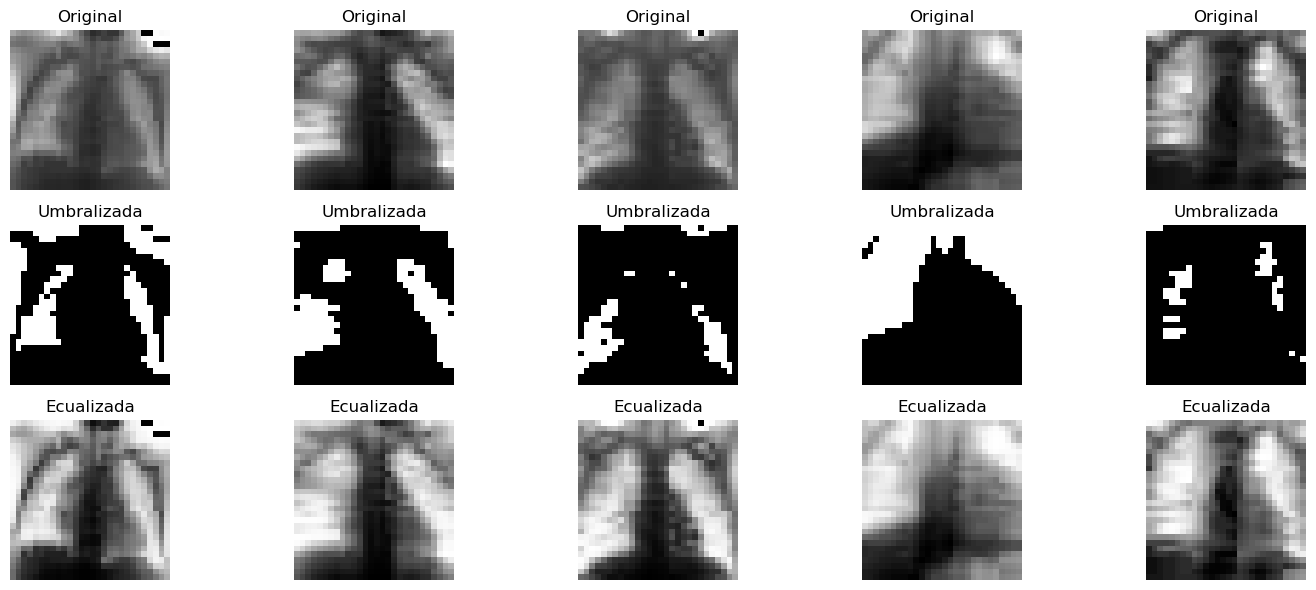

In [4]:
# Función para aplicar umbralización
def umbralizacion(imagen):
    return cv.threshold(imagen, 127, 255, cv.THRESH_BINARY)[1]

# Función para aplicar equalización del histograma
def ecualizacion_histograma(imagen):
    return cv.equalizeHist(imagen)

# Función de preprocesamiento para una sola imagen (con ecualización unicamente)
def preprocesar_imagen(img):
    img = np.array(img).squeeze()  # Convertir la imagen a array y reducir dimensiones si es necesario
    img = (img * 255).astype(np.uint8)  # Convertir a uint8 para procesamiento
    
    # Aplicar ecualización de histograma a la imagen original
    img_ecualizada = ecualizacion_histograma(img)
    
    return img_ecualizada.flatten()

# Función de preprocesamiento para una sola imagen (con umbralización y ecualización para visualización)
def visualizar_umbralizacion_y_ecualizacion(img):
    img = np.array(img).squeeze()  # Convertir la imagen a numpy y reducir dimensiones si es necesario
    img = (img * 255).astype(np.uint8)  # Convertir a uint8 para procesamiento

    # Aplicar umbralización
    img_umbralizada = umbralizacion(img)
    
    # Aplicar ecualización de histograma a la imagen original
    img_ecualizada = ecualizacion_histograma(img)
    
    return img_umbralizada, img_ecualizada

# Función para mostrar visualización paso a paso
def mostrar_procesamiento(dataset, num_imagenes=5):
    plt.figure(figsize=(15, 6))
    for i in range(num_imagenes):
        # Imagen original
        img_original = np.array(dataset[i][0]).squeeze() * 255
        img_original = img_original.astype(np.uint8)
        
        # Aplicar preprocesamiento a la imagen
        img_umbralizada, img_ecualizada = visualizar_umbralizacion_y_ecualizacion(dataset[i][0])

        # Mostrar la imagen original
        plt.subplot(3, num_imagenes, i + 1)
        plt.imshow(img_original, cmap='gray')
        plt.title("Original")
        plt.axis('off')

        # Mostrar la imagen umbralizada
        plt.subplot(3, num_imagenes, i + 1 + num_imagenes)
        plt.imshow(img_umbralizada, cmap='gray')
        plt.title("Umbralizada")
        plt.axis('off')

        # Mostrar la imagen ecualizada
        plt.subplot(3, num_imagenes, i + 1 + 2 * num_imagenes)
        plt.imshow(img_ecualizada, cmap='gray')
        plt.title("Ecualizada")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show() 

# Visualizar 5 imágenes del conjunto de entrenamiento
mostrar_procesamiento(train_set, num_imagenes=5)

### **2. Selección del Número de Componentes de PCA Basado en la Varianza Explicada**

La reducción de dimensionalidad es un paso crucial para disminuir la complejidad de los datos sin perder información importante. Aquí utilizamos el Análisis de Componentes Principales (PCA) para encontrar una representación simplificada de las imágenes. En particular, buscamos retener solo las componentes necesarias para explicar el 90% de la varianza, lo cual mantiene la mayor parte de la información relevante mientras reduce el riesgo de sobreajuste.

Número óptimo de componentes para explicar, al menos, el 90.0% de la varianza: 93


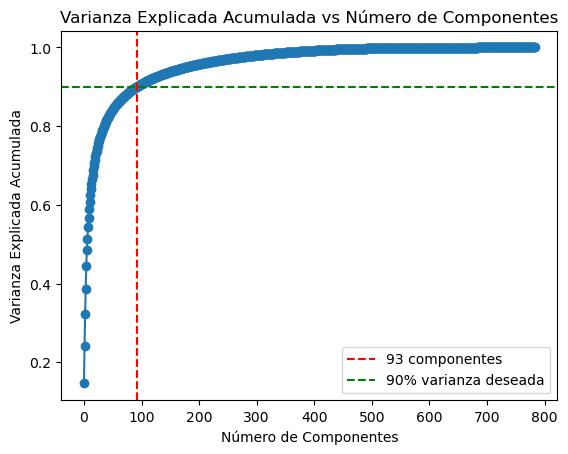

In [5]:
# Preprocesar las imágenes de entrenamiento, prueba y validación
X_train_procesado = np.array([preprocesar_imagen(img) for img in train_imgs])
X_val_procesado = np.array([preprocesar_imagen(img) for img in val_imgs])
X_test_procesado = np.array([preprocesar_imagen(img) for img in test_imgs])

y_train = train_labels
y_val = val_labels
y_test = test_labels

# Umbral de varianza explicada deseado (90%)
varianza_deseada = 0.90

# Aplicamos PCA sin especificar n_components para obtener toda la varianza explicada
pca = PCA()
pca.fit(X_train_procesado)

# Calcular la varianza explicada acumulada
varianza_explicada_acumulada = np.cumsum(pca.explained_variance_ratio_)

# Encontrar el número mínimo de componentes que explican al menos el 90% de la varianza
n_componentes_optimo = np.argmax(varianza_explicada_acumulada >= varianza_deseada) + 1

print(f"Número óptimo de componentes para explicar, al menos, el {varianza_deseada * 100}% de la varianza: {n_componentes_optimo}")

# Graficar la varianza explicada acumulada
plt.plot(varianza_explicada_acumulada, marker='o')
plt.xlabel("Número de Componentes")
plt.ylabel("Varianza Explicada Acumulada")
plt.axvline(n_componentes_optimo - 1, color='red', linestyle='--', label=f'{n_componentes_optimo} componentes')
plt.axhline(varianza_deseada, color='green', linestyle='--', label=f'{int(varianza_deseada * 100)}% varianza deseada')
plt.legend()
plt.title("Varianza Explicada Acumulada vs Número de Componentes")
plt.show()

# Aplicar PCA con el número óptimo de componentes
pca = PCA(n_components=n_componentes_optimo, random_state=42)
X_train_pca = pca.fit_transform(X_train_procesado)
X_val_pca = pca.transform(X_val_procesado)
X_test_pca = pca.transform(X_test_procesado)


### **3. Entrenamiento y Búsqueda de Hiperparámetros para MLP y SVM**

El modelo MLP (Multi-Layer Perceptron) es una red neuronal de múltiples capas que se utiliza ampliamente para problemas de clasificación. Para maximizar su rendimiento, realizamos una búsqueda de hiperparámetros usando GridSearchCV, probando combinaciones de tamaños de capas ocultas, tasas de aprendizaje, regularización y tamaño de batch. Esta búsqueda sistemática ayuda a encontrar el mejor conjunto de parámetros para balancear la precisión y la sensibilidad del modelo.

In [6]:
# Definir los parámetros para la búsqueda de hiperparámetros para MLP
param_grid_mlp = {
    'hidden_layer_sizes': [(64,), (128,), (256,)],
    'learning_rate_init': [0.01, 0.001, 0.0001],
    'alpha': [0.01, 0.1, 1],
    'batch_size': [107, 214, 428]
}

mlp_clf = MLPClassifier(random_state=42, early_stopping=True, activation='relu')
grid_search_mlp = GridSearchCV(mlp_clf, param_grid_mlp, cv=3, scoring='accuracy', verbose=2)
grid_search_mlp.fit(X_train_pca, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END alpha=0.01, batch_size=107, hidden_layer_sizes=(64,), learning_rate_init=0.01; total time=   0.2s
[CV] END alpha=0.01, batch_size=107, hidden_layer_sizes=(64,), learning_rate_init=0.01; total time=   0.2s
[CV] END alpha=0.01, batch_size=107, hidden_layer_sizes=(64,), learning_rate_init=0.01; total time=   0.2s
[CV] END alpha=0.01, batch_size=107, hidden_layer_sizes=(64,), learning_rate_init=0.001; total time=   0.3s
[CV] END alpha=0.01, batch_size=107, hidden_layer_sizes=(64,), learning_rate_init=0.001; total time=   0.3s
[CV] END alpha=0.01, batch_size=107, hidden_layer_sizes=(64,), learning_rate_init=0.001; total time=   0.2s
[CV] END alpha=0.01, batch_size=107, hidden_layer_sizes=(64,), learning_rate_init=0.0001; total time=   0.5s
[CV] END alpha=0.01, batch_size=107, hidden_layer_sizes=(64,), learning_rate_init=0.0001; total time=   1.3s
[CV] END alpha=0.01, batch_size=107, hidden_layer_sizes=(64,), learning_rat

GridSearchCV(cv=3,
             estimator=MLPClassifier(early_stopping=True, random_state=42),
             param_grid={'alpha': [0.01, 0.1, 1], 'batch_size': [107, 214, 428],
                         'hidden_layer_sizes': [(64,), (128,), (256,)],
                         'learning_rate_init': [0.01, 0.001, 0.0001]},
             scoring='accuracy', verbose=2)

In [7]:
# Obtener resultados de MLP y ordenar por el rank de la puntuación
cv_results_mlp = pd.DataFrame(grid_search_mlp.cv_results_).sort_values(by='rank_test_score')
print("Resultados MLP ordenados:")
print(cv_results_mlp[['rank_test_score', 'param_hidden_layer_sizes', 'param_learning_rate_init', 'param_alpha', 'mean_test_score']])

Resultados MLP ordenados:
    rank_test_score param_hidden_layer_sizes param_learning_rate_init  \
51                1                   (256,)                     0.01   
24                2                   (256,)                     0.01   
78                3                   (256,)                     0.01   
60                4                   (256,)                     0.01   
39                5                   (128,)                     0.01   
..              ...                      ...                      ...   
11               77                    (64,)                   0.0001   
38               77                    (64,)                   0.0001   
74               79                    (64,)                   0.0001   
47               80                    (64,)                   0.0001   
20               80                    (64,)                   0.0001   

   param_alpha  mean_test_score  
51         0.1         0.956459  
24        0.01         0.9558

In [8]:
# Evaluación en conjunto de validación
best_mlp = grid_search_mlp.best_estimator_
mlp_val_score = best_mlp.score(X_val_pca, y_val)
print(f"Exactitud MLP en conjunto de validación: {mlp_val_score:.2f}")

Exactitud MLP en conjunto de validación: 0.96


El modelo SVM (Support Vector Machine) es conocido por su eficacia en problemas de clasificación binaria. Ajustamos el modelo usando GridSearchCV para optimizar los parámetros C (que controla la penalización de errores) y gamma (que define la influencia de cada muestra). Estas configuraciones permiten al modelo encontrar el margen óptimo entre las clases, mejorando su capacidad para distinguir casos positivos y negativos.

In [9]:
# Parámetros para SVM
param_grid_svm = {'C': [0.01, 0.1, 1, 10, 100], 'gamma': ['scale', 'auto']}
svm_clf = SVC(kernel='rbf', random_state=42)
grid_search_svm = GridSearchCV(svm_clf, param_grid_svm, cv=5, scoring='accuracy', verbose=2)
grid_search_svm.fit(X_train_pca, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ................................C=0.01, gamma=scale; total time=   0.5s
[CV] END ................................C=0.01, gamma=scale; total time=   0.4s
[CV] END ................................C=0.01, gamma=scale; total time=   0.4s
[CV] END ................................C=0.01, gamma=scale; total time=   0.4s
[CV] END ................................C=0.01, gamma=scale; total time=   0.4s
[CV] END .................................C=0.01, gamma=auto; total time=   0.7s
[CV] END .................................C=0.01, gamma=auto; total time=   0.7s
[CV] END .................................C=0.01, gamma=auto; total time=   0.7s
[CV] END .................................C=0.01, gamma=auto; total time=   0.7s
[CV] END .................................C=0.01, gamma=auto; total time=   0.7s
[CV] END .................................C=0.1, gamma=scale; total time=   0.2s
[CV] END .................................C=0.1,

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'gamma': ['scale', 'auto']},
             scoring='accuracy', verbose=2)

In [10]:
# Obtener resultados de SVM y ordenar por el rank de la puntuación
cv_results_svm = pd.DataFrame(grid_search_svm.cv_results_).sort_values(by='rank_test_score')
print("\nResultados SVM ordenados:")
print(cv_results_svm[['rank_test_score', 'param_C', 'param_gamma', 'mean_test_score']])


Resultados SVM ordenados:
   rank_test_score param_C param_gamma  mean_test_score
4                1       1       scale         0.964318
6                2      10       scale         0.964105
8                3     100       scale         0.963680
2                4     0.1       scale         0.943288
0                5    0.01       scale         0.817970
5                6       1        auto         0.742566
7                6      10        auto         0.742566
9                6     100        auto         0.742566
1                9    0.01        auto         0.742141
3                9     0.1        auto         0.742141


In [11]:
# Evaluación en conjunto de validación
best_svm = grid_search_svm.best_estimator_
svm_val_score = best_svm.score(X_val_pca, y_val)
print(f"Exactitud SVM en conjunto de validación: {svm_val_score:.2f}")

Exactitud SVM en conjunto de validación: 0.96


In [12]:
# Mostrar el mejor estimador de cada modelo
print("\nMejor modelo MLP:", grid_search_mlp.best_estimator_)
print("Mejor modelo SVM:", grid_search_svm.best_estimator_)


Mejor modelo MLP: MLPClassifier(alpha=0.1, batch_size=428, early_stopping=True,
              hidden_layer_sizes=(256,), learning_rate_init=0.01,
              random_state=42)
Mejor modelo SVM: SVC(C=1, random_state=42)


## **3. Evaluación del Modelo**
Evaluamos el rendimiento de los modelos en el conjunto de prueba con métricas de clasificación y visualizamos la matriz de confusión para cada uno

In [13]:
# Evaluación de MLP en conjunto de prueba
y_pred_mlp = best_mlp.predict(X_test_pca)
# Reporte de clasificación para MLP
print("Reporte de clasificación para MLP:\n", classification_report(y_test, y_pred_mlp))

Reporte de clasificación para MLP:
               precision    recall  f1-score   support

           0       0.96      0.68      0.80       234
           1       0.84      0.98      0.90       390

    accuracy                           0.87       624
   macro avg       0.90      0.83      0.85       624
weighted avg       0.88      0.87      0.86       624



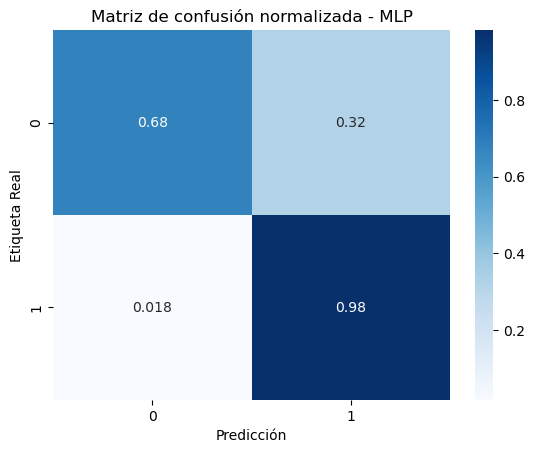

In [14]:
# Evaluación de MLP en conjunto de prueba
cm_mlp = confusion_matrix(y_test, y_pred_mlp, normalize='true')
sns.heatmap(cm_mlp, annot=True, cmap='Blues')
plt.title("Matriz de confusión normalizada - MLP")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.show()

In [15]:
# Sensibilidad y especificidad para MLP
sensitivity_mlp = recall_score(y_test, y_pred_mlp)
specificity_mlp = cm_mlp[0, 0] / (cm_mlp[0, 0] + cm_mlp[0, 1])  # TN / (TN + FP)

print(f"Sensibilidad (Recall) para MLP: {sensitivity_mlp:.2f}")
print(f"Especificidad para MLP: {specificity_mlp:.2f}")

Sensibilidad (Recall) para MLP: 0.98
Especificidad para MLP: 0.68


In [16]:
# Evaluación de SVM en conjunto de prueba
y_pred_svm = best_svm.predict(X_test_pca)

# Reporte de clasificación para SVM
print("Reporte de clasificación para SVM:\n", classification_report(y_test, y_pred_svm))

Reporte de clasificación para SVM:
               precision    recall  f1-score   support

           0       0.96      0.62      0.76       234
           1       0.81      0.98      0.89       390

    accuracy                           0.85       624
   macro avg       0.89      0.80      0.82       624
weighted avg       0.87      0.85      0.84       624



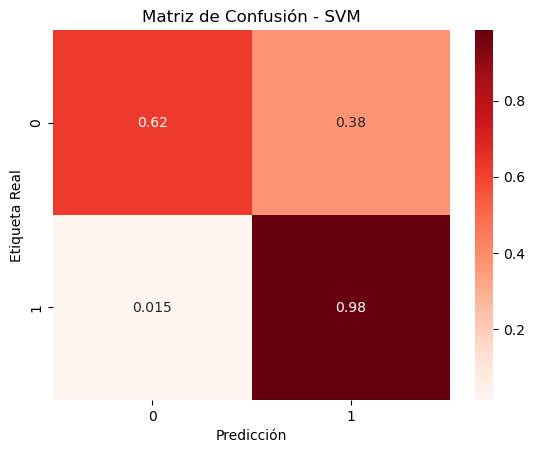

In [17]:

cm_svm = confusion_matrix(y_test, y_pred_svm, normalize='true')
sns.heatmap(cm_svm, annot=True, cmap='Reds')
plt.title("Matriz de Confusión - SVM")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.show()

## **4. Aplicación del modelo**
---

Para aplicar el modelo en un entorno práctico, definimos una función para predecir el estado de salud de una nueva imagen usando el flujo de preprocesamiento y PCA.

In [18]:
def predecir_imagen(model, pca, imagen):
    # Aplicar el flujo de preprocesamiento a la imagen de entrada
    img_ecualizada = preprocesar_imagen(imagen)
    img_reducida = pca.transform([img_ecualizada])
    prediccion = model.predict(img_reducida)
    return "Neumonía" if prediccion[0] == 1 else "Normal"

# Ejemplo de uso con una imagen del conjunto de prueba
nueva_imagen = test_set.imgs[5]
print("Predicción:", predecir_imagen(best_mlp, pca, nueva_imagen))
print("Predicción:", predecir_imagen(best_svm, pca, nueva_imagen))

Predicción: Neumonía
Predicción: Neumonía


## **Créditos**
---

* **Profesor:** [Fabio Augusto Gonzalez](https://dis.unal.edu.co/~fgonza/)
* **Asistente docente :**
  * [Rosa Alejandra Superlano Esquibel](https://www.linkedin.com/in/alejandrasuperlano/).
* **Diseño de imágenes:**
    - [Rosa Alejandra Superlano Esquibel](https://www.linkedin.com/in/alejandrasuperlano/).
* **Coordinador de virtualización:**
    - [Edder Hernández Forero](https://www.linkedin.com/in/edder-hernandez-forero-28aa8b207/).

**Universidad Nacional de Colombia** - *Facultad de Ingeniería*